In [1]:
import csv
import cv2
import numpy as np
import datetime
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
import matplotlib.image as mpimg
import pandas as pd

In [2]:
from keras.preprocessing import image
from keras.models import Model
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Lambda, Dropout
from keras.optimizers import Adam
from keras.layers import Convolution2D, ELU,Conv2D,MaxPooling2D
from keras.layers.convolutional import Cropping2D

In [3]:
img_loc = './Data/data/IMG/'
csv_file_loc = './Data/data/driving_log.csv'
data_loc = './Data/data/'

In [4]:
data_df = pd.read_csv(csv_file_loc, names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

X = data_df[['center','left','right']].values
y = data_df['steering'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

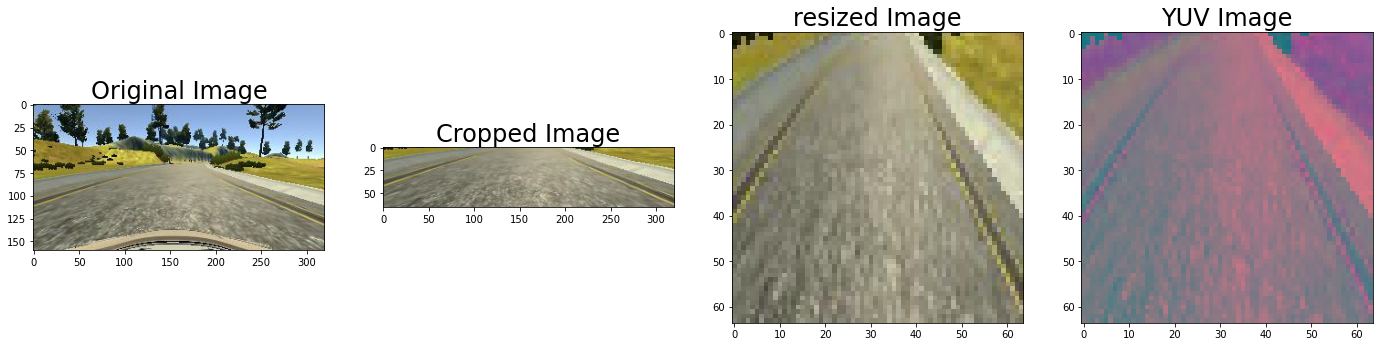

In [5]:
from utils import crop,resize,rgb2yuv,preprocess
center, left, right = X_valid[1]
image = mpimg.imread(os.path.join(data_loc, center.strip()))
cropped_image = crop(image)
resize_image = resize(cropped_image)
yuv_image = rgb2yuv(resize_image)
f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
ax1.set_title("Original Image",fontsize=24)
ax1.imshow(image)
ax2.set_title("Cropped Image",fontsize=24)
ax2.imshow(cropped_image)
ax3.set_title("resized Image",fontsize=24)
ax3.imshow(resize_image)
ax4.set_title("YUV Image",fontsize=24)
ax4.imshow(yuv_image)

In [6]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64,64, 3
BATCH_SIZE  = 32

def load_image(image_file):
    return mpimg.imread(os.path.join(data_loc, image_file.strip()))

def get_image_data(center, left, right, steering_angle):
    
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(left), steering_angle + 0.2
    elif choice == 1:
        return load_image(right), steering_angle - 0.2
    return load_image(center), steering_angle

def flip_image(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -float(steering_angle)
    return image, steering_angle

def batch_generator(image_paths, steering_angles):

    images = np.empty([BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    angles = np.empty(BATCH_SIZE)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            if steering_angle == 'steering':
                continue
            if center == 'center':
                continue
            steering_angle = float(steering_angle)
            image,steering_angle = get_image_data(center, left, right, steering_angle)
            # add the image and steering angle and flipped image and steering angle to the barch
            # According NVIDIA model convert the image YUV format
            image = preprocess(image)
            images[i] = image#cv2.cvtColor(image, cv2.COLOR_RGB2YUV) 
            angles[i] = steering_angle
            images[i+1], angles[i+1]= flip_image(image,steering_angle)
            i += 2
            if i >= BATCH_SIZE:
                break
        yield images, angles
    

In [7]:
model = Sequential()
model.add(Lambda(lambda image: image / 128.0 - 1., input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)))
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="elu"))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="elu"))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="elu"))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Flatten())
model.add(Dense(1164))
model.add(Dropout(0.8))
model.add(Dense(100))
model.add(Dropout(0.8))
model.add(Dense(50))
#model.add(Dropout(0.8))
model.add(Dense(10))
#model.add(Dropout(0.8))
model.add(Dense(1))
model.summary()
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [8]:
model.fit(batch_generator(X_train, y_train),
                        steps_per_epoch = len(X_train),
                        epochs = 10,
                        shuffle = True,
                        validation_data=batch_generator(X_valid, y_valid),
                        validation_steps=len(X_valid),
                        verbose=1)


Epoch 1/10
6429/6429 [==============================] - 613s 95ms/step - loss: 0.0233 - accuracy: 0.1822 - val_loss: 0.0161 - val_accuracy: 0.1843
Epoch 2/10
6429/6429 [==============================] - 535s 83ms/step - loss: 0.0183 - accuracy: 0.1792 - val_loss: 0.0141 - val_accuracy: 0.1824
Epoch 3/10
6429/6429 [==============================] - 556s 86ms/step - loss: 0.0152 - accuracy: 0.1800 - val_loss: 0.0140 - val_accuracy: 0.1845
Epoch 4/10
6429/6429 [==============================] - 467s 73ms/step - loss: 0.0126 - accuracy: 0.1813 - val_loss: 0.0132 - val_accuracy: 0.1826
Epoch 5/10
6429/6429 [==============================] - 481s 75ms/step - loss: 0.0105 - accuracy: 0.1809 - val_loss: 0.0137 - val_accuracy: 0.1800
Epoch 6/10
6429/6429 [==============================] - 470s 73ms/step - loss: 0.0085 - accuracy: 0.1797 - val_loss: 0.0148 - val_accuracy: 0.1798
Epoch 7/10
6429/6429 [==============================] - 467s 73ms/step - loss: 0.0069 - accuracy: 0.1785 - val_loss: 0

In [9]:
model.save('model.h5')